<a href="https://colab.research.google.com/github/gregoriussitindaon/subscription-churn-prediction/blob/main/notebooks/01_churn_eda_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. IMPORT LIBRARY**

# Telco Customer Churn Prediction

Tujuan analisis:
- Mengidentifikasi faktor-faktor utama yang mendorong churn.
- Membangun model prediksi churn yang dapat membantu tim bisnis menargetkan pelanggan berisiko tinggi.
- Menyajikan insight yang dapat diterjemahkan menjadi aksi nyata (bukan hanya metrik teknis).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

**2. LOAD DATA**

In [6]:
base_path = '/content/drive/MyDrive/data_telco/'  # sesuaikan

df = pd.read_csv(base_path + 'Telco-Customer-Churn.csv')

**3. CEK STRUKTUR & BERSIHKAN DATA**

## Data Understanding & Cleaning

Beberapa langkah penting:
- Menghapus baris dengan nilai kosong pada kolom numerik kunci.
- Memastikan variabel target `Churn` dalam bentuk biner (Yes/No → 1/0).
- Mengidentifikasi variabel yang secara bisnis masuk akal sebagai prediktor, seperti:
  - jenis kontrak,
  - metode pembayaran,
  - lama berlangganan,
  - layanan tambahan yang digunakan,
  - biaya bulanan dan total.
Keputusan ini meniru praktik nyata: sebelum membangun model, definisi variabel harus jelas dan bersih.

In [7]:
df.head()
df.info()
df.describe(include='all').T
df['Churn'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,proportion
Churn,
No,0.73463
Yes,0.26537


In [12]:
# Beberapa dataset Telco punya TotalCharges sebagai object → harus dibersihkan:
# convert TotalCharges to numeric (kalau ada)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.isna().sum()

# TANGANI MISSING:
df = df.dropna()

**4. ENCODE TARGET & FITUR KATERGORIAL**

In [13]:
# encode target
df['Churn_Flag'] = df['Churn'].map({'Yes': 1, 'No': 0})

# drop kolom ID yang tidak informatif
id_cols = [col for col in df.columns if 'customerID' in col.lower()]
df = df.drop(columns=id_cols)

# pisahkan fitur kategorikal & numerik
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in ['Churn']]  # selain target asli

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [c for c in num_cols if c != 'Churn_Flag']

cat_cols, num_cols

(['customerID',
  'gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'])

In [14]:
# ONE-HOT ENCODING
df_encoded = pd.get_dummies(df[cat_cols], drop_first=True)
data_model = pd.concat([df[num_cols], df_encoded, df['Churn_Flag']], axis=1)

data_model.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,customerID_0013-SMEOE,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Flag
0,0,1,29.85,29.85,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,0
1,0,34,56.95,1889.50,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,0
2,0,2,53.85,108.15,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,1
3,0,45,42.30,1840.75,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,0
4,0,2,70.70,151.65,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,1


**5. TRAIN-TES SPLIT & SCALING**

In [15]:
X = data_model.drop('Churn_Flag', axis=1)
y = data_model['Churn_Flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**6. MODEL 1 - LOGISTIC REGRESSION (BASELINE INTERPRETABLE)**

In [16]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      1033
           1       0.70      0.30      0.42       374

    accuracy                           0.78      1407
   macro avg       0.74      0.63      0.64      1407
weighted avg       0.77      0.78      0.75      1407

ROC-AUC: 0.8295383364997853


**7. MODEL 2 - RANDOM FOREST (NON-LINEAR, FEATURE IMPORTANCE)**

In [17]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

Random Forest
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.64      0.45      0.53       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.78      1407

ROC-AUC: 0.8303692065579203


In [19]:
# FEATURE IMPORTANCE
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)
top_features

,0
TotalCharges,0.103104
tenure,0.094455
MonthlyCharges,0.080734
InternetService_Fiber optic,0.029181
PaymentMethod_Electronic check,0.025826
Contract_Two year,0.023449
OnlineSecurity_Yes,0.020027
TechSupport_Yes,0.019377
Contract_One year,0.018104
PaperlessBilling_Yes,0.017755


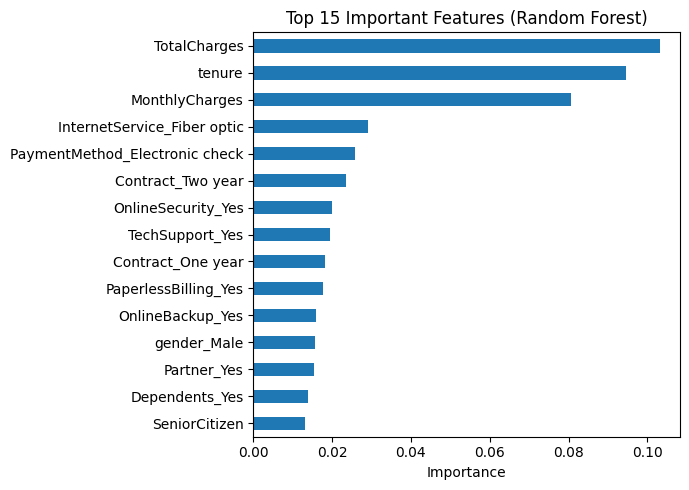

In [20]:
plt.figure(figsize=(7,5))
top_features.sort_values().plot(kind='barh')
plt.title('Top 15 Important Features (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Gambar tersebut menunjukkan bahwa TotalCharges, tenure, dan MonthlyCharges menjadi penentu utama prediksi churn: pelanggan baru dengan akumulasi pembayaran rendah dan biaya bulanan tinggi cenderung lebih berisiko berhenti. Fitur seperti InternetService_Fiber optic, PaymentMethod_Electronic check, serta tipe kontrak dan layanan tambahan mengindikasikan bahwa paket mahal tanpa kontrak jangka panjang atau tanpa value-added service meningkatkan potensi churn, sedangkan kontrak 1–2 tahun dan layanan tambahan cenderung menahan pelanggan. Faktor demografis berperan lebih kecil, sehingga strategi retensi sebaiknya diarahkan pada perilaku penggunaan, struktur kontrak, dan harga, dengan tetap mengingat bahwa feature importance ini bersifat korelasional dan perlu dikonfirmasi dengan analisis deskriptif pendukung.

**8. CONFUSION MATRIX + ROC CURVE**

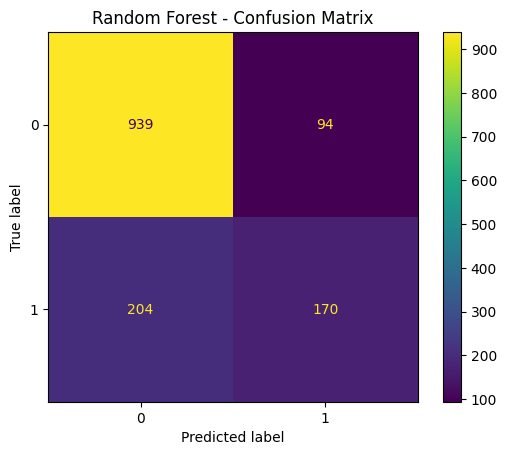

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title('Random Forest - Confusion Matrix')
plt.show()

Confusion matrix menunjukkan bahwa model Random Forest sangat baik dalam mengenali pelanggan yang tidak churn (939 benar diprediksi bertahan, hanya 94 salah diklasifikasikan sebagai churn), tetapi masih lemah dalam menangkap pelanggan yang benar-benar churn: dari seluruh pelanggan churn, hanya 170 yang terdeteksi, sementara 204 terlewat dan diklasifikasikan sebagai tidak churn. Secara bisnis, ini berarti risiko utama model saat ini adalah under-detection terhadap pelanggan berisiko tinggi, sehingga potensi kehilangan pendapatan tetap besar jika threshold dan strategi model tidak disesuaikan. Untuk konteks manajemen churn, diperlukan penyesuaian ambang probabilitas atau penimbangan ulang kelas agar recall pada kelas churn meningkat, meskipun kemungkinan menambah sedikit false positive, karena biaya mencegah churn umumnya lebih rendah dibanding biaya kehilangan pelanggan.

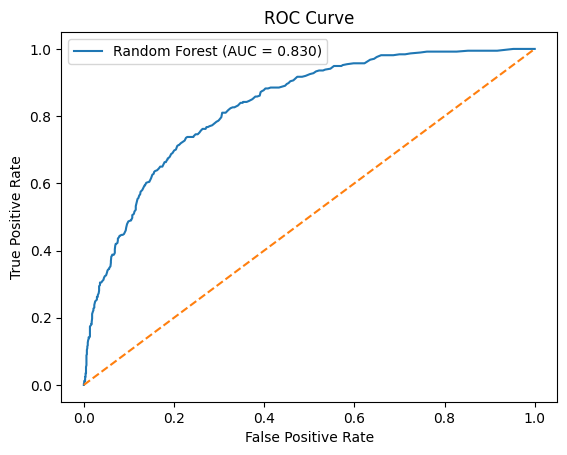

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Kurva ROC menunjukkan bahwa model Random Forest memiliki kemampuan diskriminasi yang baik dengan nilai AUC sebesar 0,83, jauh di atas garis acak (0,5). Artinya, secara probabilistik model cukup efektif membedakan pelanggan yang berisiko churn dan yang tidak. Namun, pemilihan threshold keputusan tetap krusial: untuk konteks manajemen churn, perusahaan sebaiknya menggeser threshold agar meningkatkan true positive rate (menangkap lebih banyak pelanggan berisiko), meskipun konsekuensinya adalah kenaikan false positive yang masih dapat diterima dibanding potensi kehilangan pendapatan akibat churn yang tidak terdeteksi.

### Business Recommendations

1. **Targeted Retention Campaign**
   Gunakan skor probabilitas churn untuk membuat daftar prioritas pelanggan yang perlu dihubungi.
   Fokus pada:
   - pelanggan dengan kontrak bulanan,
   - tenure rendah,
   - biaya bulanan tinggi,
   - menggunakan metode pembayaran dengan korelasi churn tinggi.

2. **Incentive for Long-Term Contracts**
   Tawarkan diskon atau benefit tambahan bagi pelanggan yang bersedia pindah ke kontrak tahunan.
   Hal ini menurunkan fleksibilitas untuk churn dan meningkatkan kepastian pendapatan.

3. **High-Risk Segment Monitoring**
   Implementasikan dashboard internal yang menampilkan:
   - distribusi probabilitas churn,
   - tren churn per segmen layanan,
   - respon pelanggan terhadap kampanye retensi.

4. **Continuous Model Improvement**
   Model perlu dievaluasi berkala dengan data terbaru:
   - memperbarui fitur (misalnya aktivitas penggunaan),
   - mengukur kembali trade-off antara recall dan biaya retensi.

Pendekatan ini menunjukkan bagaimana _machine learning_ tidak berhenti pada metrik teknis, tetapi diintegrasikan ke dalam keputusan bisnis yang konkret dan terukur.